# Cats and Dogs Classification

### Import Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from PIL import Image
import random  


### Data Loading and Preprocessing Class

In [ ]:
# This class is responsible for loading image data from the specified directory,
# preprocessing the images (resizing and normalizing), and splitting the data
# into training and testing sets.

class ImageDataLoader:
    """
    Loads, preprocesses, and splits image data for cat vs. dog classification.
    """
    def __init__(self, data_dir, img_size=(128, 128), train_test_split_ratio=0.2, random_seed=42):
        """
        Initializes the ImageDataLoader.

        Args:
            data_dir (str): Path to the main data directory containing 'PetImages'.
            img_size (tuple): Target size (width, height) for resizing images.
            train_test_split_ratio (float): Ratio of data to use for testing (e.g., 0.2 for 20%).
            random_seed (int): Seed for random number generators to ensure reproducibility.
        """
        self.data_dir = data_dir
        self.img_size = img_size
        self.categories = ['Cat', 'Dog'] 
        self.train_data = []
        self.train_labels = []
        self.test_data = []
        self.test_labels = []
        self.train_test_split_ratio = train_test_split_ratio
        self.random_seed = random_seed
        random.seed(self.random_seed)
        np.random.seed(self.random_seed)

    def load_and_preprocess_data(self):
        """
        Loads images from the directory, preprocesses them, and splits into train and test sets.

        Returns:
            tuple: A tuple containing training data, training labels, testing data, and testing labels.
                   (train_data, train_labels, test_data, test_labels)
        """
        all_data = []
        all_labels = []

        pet_images_path = os.path.join(self.data_dir, 'PetImages')
        for i, category in enumerate(self.categories):
            path = os.path.join(pet_images_path, category)
            for img_file in os.listdir(path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')): # Filter for image files
                    img_path = os.path.join(path, img_file)
                    try:
                        img = Image.open(img_path).convert('RGB').resize(self.img_size)
                        img_array = np.array(img) / 255.0  # Normalize pixel values
                        if img_array.shape == (self.img_size[0], self.img_size[1], 3): # Ensure correct shape
                            all_data.append(img_array)
                            all_labels.append(i)  # 0 for Cat, 1 for Dog
                        else:
                            print(f"Skipping image with incorrect shape: {img_path} - shape: {img_array.shape}")
                    except Exception as e:
                        print(f"Error loading or processing image: {img_path} - {e}")
                else:
                    print(f"Skipping non-image file: {os.path.join(path, img_file)}")

        # Shuffle the data and labels together
        combined = list(zip(all_data, all_labels))
        random.shuffle(combined)
        shuffled_data, shuffled_labels = zip(*combined)
        shuffled_data = np.array(shuffled_data)
        shuffled_labels = np.array(shuffled_labels)

        # Perform train-test split
        split_index = int(len(shuffled_data) * (1 - self.train_test_split_ratio))
        self.train_data = shuffled_data[:split_index]
        self.train_labels = shuffled_labels[:split_index]
        self.test_data = shuffled_data[split_index:]
        self.test_labels = shuffled_labels[split_index:]

        return self.train_data, self.train_labels, self.test_data, self.test_labels



### Model Building Class

In [ ]:
# This class defines and compiles the Convolutional Neural Network (CNN) model
# used for image classification. It also includes methods for training,
# evaluating, and making predictions with the model.

class ImageClassifierModel:
    """
    Builds, compiles, trains, evaluates, and predicts with an image classification model (CNN).
    """
    def __init__(self, input_shape, num_classes):
        """
        Initializes the ImageClassifierModel.

        Args:
            input_shape (tuple): Shape of the input images (height, width, channels).
            num_classes (int): Number of output classes (2 for binary cat vs. dog).
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model()

    def _build_model(self):
        """
        Builds the CNN model architecture.
        """
        model = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='sigmoid')  # Sigmoid for binary
        ])
        return model

    def compile_model(self, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
        """
        Compiles the model with the specified optimizer, loss function, and metrics.

        Args:
            optimizer (str): Optimization algorithm to use (e.g., 'adam').
            loss (str): Loss function to minimize during training (e.g., 'binary_crossentropy').
            metrics (list): List of metrics to evaluate during training and testing (e.g., ['accuracy']).
        """
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train_model(self, x_train, y_train, epochs=20, validation_data=None):
        """
        Trains the model on the provided training data.

        Args:
            x_train (np.array): Training data.
            y_train (np.array): Training labels.
            epochs (int): Number of training epochs.
            validation_data (tuple): Tuple containing validation data and labels (optional).

        Returns:
            History: History object containing training metrics.
        """
        history = self.model.fit(x_train, y_train, epochs=epochs, validation_data=validation_data)
        return history

    def evaluate_model(self, x_test, y_test, verbose=0):
        """
        Evaluates the model on the provided test data.

        Args:
            x_test (np.array): Test data.
            y_test (np.array): Test labels.
            verbose (int): Verbosity mode (0 = silent, 1 = progress bar).

        Returns:
            tuple: A tuple containing the test loss and test accuracy.
        """
        loss, accuracy = self.model.evaluate(x_test, y_test, verbose=verbose)
        return loss, accuracy

    def predict(self, x):
        """
        Makes predictions on the input data.

        Args:
            x (np.array): Input data for prediction.

        Returns:
            np.array: Array of prediction probabilities.
        """
        return self.model.predict(x)
    
    def predict_single_image(self, img_path, target_size):
        """
        Predicts the class of a single image from a file path.

        Args:
            img_path (str): Path to the image file.
            target_size (tuple): Target size (width, height) for resizing the image.

        Returns:
            float or None: Probability of the image belonging to the 'Dog' class, or None if an error occurred.
        """
        try:
            img = Image.open(img_path).convert('RGB').resize(target_size)
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0) 
            prediction = self.predict(img_array)
            return prediction[0][0] # Get the probability for the 'Dog' class
        except Exception as e:
            print(f"Error predicting image: {img_path} - {e}")
            return None

### Execution Block

Skipping non-image file: data/PetImages/Cat/Thumbs.db
Skipping non-image file: data/PetImages/Dog/Thumbs.db
Number of training samples: 19967
Number of testing samples: 4992
Epoch 1/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 89s 189ms/step - accuracy: 0.5744 - loss: 0.6751 - val_accuracy: 0.6516 - val_loss: 0.6241
Epoch 2/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.7254 - loss: 0.5498 - val_accuracy: 0.7606 - val_loss: 0.4791
Epoch 3/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - accuracy: 0.7781 - loss: 0.4710 - val_accuracy: 0.7638 - val_loss: 0.4846
Epoch 4/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 78s 166ms/step - accuracy: 0.8154 - loss: 0.4108 - val_accuracy: 0.8253 - val_loss: 0.3978
Epoch 5/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 77s 165ms/step - accuracy: 0.8433 - loss: 0.3603 - val_accuracy: 0.8165 - val_loss: 0.3973
Epoch 6/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 78s 166ms/step - accuracy: 0.8696 - loss: 0.2976 - val_accuracy: 0.8411 - val_loss: 0.3630
Epoch 7/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 

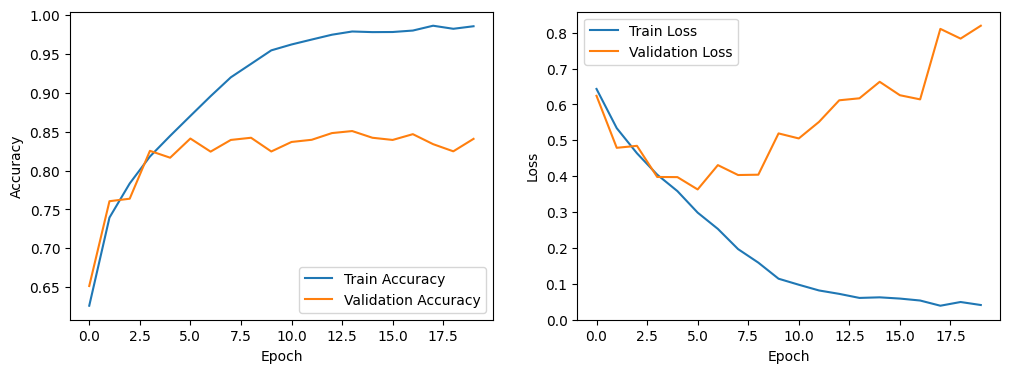

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


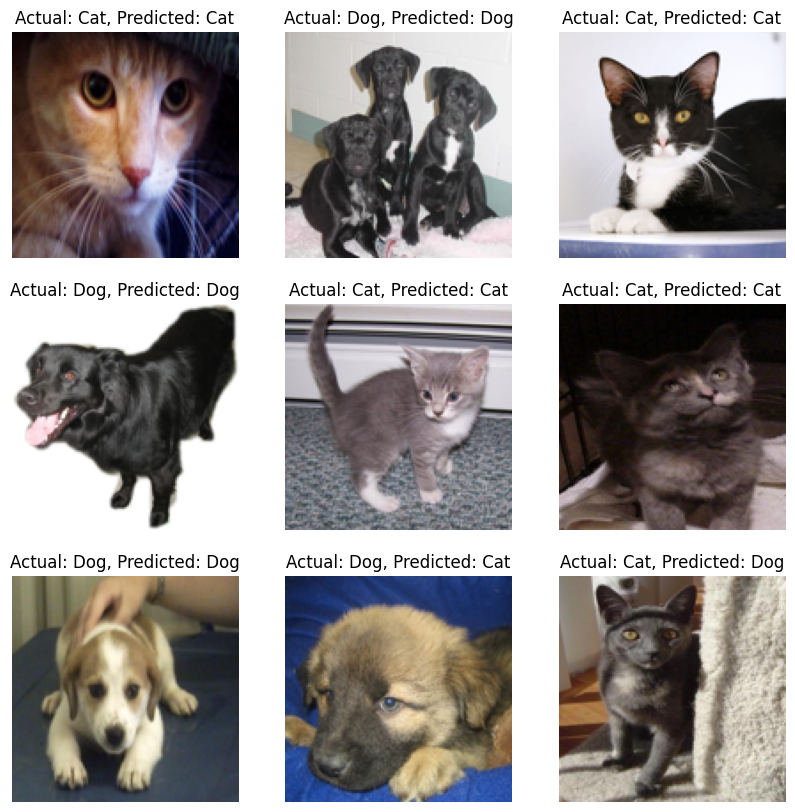

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Prediction for data/PetImages/Cat/0.jpg: Probability of being a Dog = 0.5300, Predicted class: Dog


In [16]:
# This block orchestrates the data loading, model building, training,
# evaluation, and visualization steps of the image classification project.

if __name__ == "__main__":
    # --- Data Loading and Preprocessing ---
    data_dir = 'data'  # Path to the 'data' folder containing 'PetImages'
    image_loader = ImageDataLoader(data_dir=data_dir, train_test_split_ratio=0.2)
    train_data, train_labels, test_data, test_labels = image_loader.load_and_preprocess_data()

    print(f"Number of training samples: {len(train_data)}")
    print(f"Number of testing samples: {len(test_data)}")

    # Reshape labels to have a shape of (num_samples, 1) for binary cross-entropy loss
    train_labels = np.array(train_labels).reshape(-1, 1)
    test_labels = np.array(test_labels).reshape(-1, 1)

    # Split the training data further into training and validation sets
    # Validation set is used to monitor model performance during training
    X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.25, random_state=42) #  25% of training data will be used for validation

    # --- Model Building ---
    input_shape = (128, 128, 3)
    num_classes = 1  # Binary classification (Cat or Dog)
    model_builder = ImageClassifierModel(input_shape=input_shape, num_classes=num_classes)
    model_builder.compile_model()

    # --- Model Training ---
    # Train the model on the training data, using the validation set to track performance
    history = model_builder.train_model(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

    # --- Model Evaluation ---
    # Evaluate the trained model on the unseen test data to assess its generalization ability
    loss, accuracy = model_builder.evaluate_model(test_data, test_labels)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # --- Results Visualization ---
    # Plot the training and validation accuracy and loss over epochs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # --- Making predictions on a few test images and visualizing ---
    predictions = model_builder.predict(test_data[:9])
    # Convert probabilities to binary predictions (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(test_data[i])
        plt.title(f"Actual: {image_loader.categories[test_labels[i][0]]}, Predicted: {image_loader.categories[binary_predictions[i][0]]}")
        plt.axis('off')
    plt.show()

    # --- Making a prediction on a single image ---
    sample_image_path = 'data/PetImages/Cat/0.jpg'
    prediction_probability = model_builder.predict_single_image(sample_image_path, (128, 128))

    if prediction_probability is not None:
        predicted_class = "Dog" if prediction_probability > 0.5 else "Cat"
        print(f"\nPrediction for {sample_image_path}: Probability of being a Dog = {prediction_probability:.4f}, Predicted class: {predicted_class}")